# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive


In [7]:
# Load the dataset from your Drive folder

train = loadmat('/content/drive/MyDrive/Coursera/train_32x32.mat')
test = loadmat('/content/drive/MyDrive/Coursera/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [8]:
import numpy as np

train_images = train['X']
train_labels = train['y']
train_images = np.moveaxis(train_images, -1, 0) / 255.0

test_images = test['X']
test_labels = test['y']
test_images = np.moveaxis(test_images, -1, 0) / 255.0 # current format (32,32,3,n_samples) -> (n_samples,32,32,3)

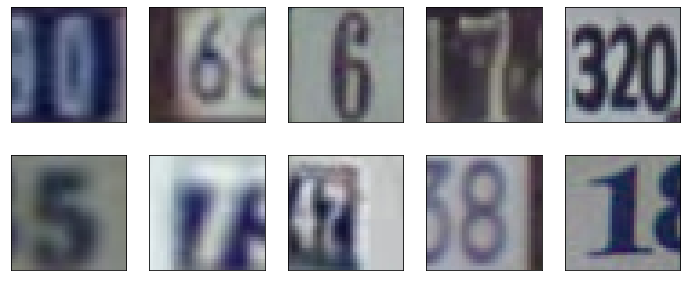

In [9]:
import matplotlib.pyplot as plt

indices = np.random.choice(train_images.shape[0], size = 10, replace = False)
samples = train_images[indices, :, :, :]

plt.figure(figsize=(12, 5)) 
for i in range(samples.shape[0]):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples[i,:,:,:])
    plt.xticks([])
    plt.yticks([])

In [10]:
train_images_gray = np.mean(train_images, axis = 3)
test_images_gray = np.mean(test_images, axis = 3)

print(train_images_gray.shape)
print(test_images_gray.shape)

(73257, 32, 32)
(26032, 32, 32)


In [11]:
#to_categorical
 
from tensorflow.keras.utils import to_categorical

cat_train_labels = to_categorical(train_labels-1) # *_labels-1 to transform current labels to (0,10] range
cat_test_labels = to_categorical(test_labels-1)

In [12]:
print("Real labels : ",train_labels[:5].reshape(1,-1) - 1, "\n")
print("categorized labels:\n",cat_train_labels[:5, :])

Real labels :  [[0 8 1 2 1]] 

categorized labels:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


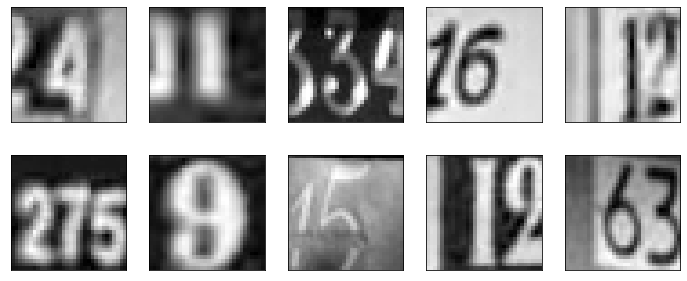

In [13]:
indices = np.random.choice(train_images_gray.shape[0], size = 10, replace = False)
samples2 = train_images_gray[indices,:, :]

plt.figure(figsize=(12, 5)) 
for i in range(samples2.shape[0]):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples2[i,:,:], cmap ='gray')
    plt.xticks([])
    plt.yticks([])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Conv2D,MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau

In [15]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs["loss"] < 1.0:
            print("Loss < 1.0, stopping training.....")
            self.model.stop_training = True
            
callback1 = myCallback()
modelcheck = ModelCheckpoint("model_checkpoint/checkpoint",
                            monitor = "loss",
                            save_best_only=True,
                            save_weights_only=True,
                            verbose = 1
                           )
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

callbacks = [callback1, modelcheck,reduce_lr]

In [ ]:
shutil.rmtree("/content/conv_model_checkpoint")
shutil.rmtree("/content/model_checkpoint")

In [16]:
def create_mlp():
  model = Sequential([
      Flatten(input_shape = (32, 32)),
      Dense(128, 'relu'),
      Dense(128, 'relu'),
      Dense(128, 'relu'),
      Dense(128, 'relu'),
      Dense(10, 'softmax')
  ])
  model.summary()
  model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

model = create_mlp()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 182,026
Trainable params: 182,026
Non-trainable params: 0
__________________________________________________

In [17]:
history = model.fit(train_images_gray, cat_train_labels,
                    validation_split = 0.15,
                    epochs = 30, batch_size = 128, callbacks=callbacks)

Epoch 1/30
487/487 [==============================] - 5s 4ms/step - loss: 2.1092 - accuracy: 0.2376 - val_loss: 1.7904 - val_accuracy: 0.3553

Epoch 00001: loss improved from inf to 2.10918, saving model to model_checkpoint/checkpoint
Epoch 2/30
487/487 [==============================] - 2s 3ms/step - loss: 1.5085 - accuracy: 0.4820 - val_loss: 1.3282 - val_accuracy: 0.5712

Epoch 00002: loss improved from 2.10918 to 1.50851, saving model to model_checkpoint/checkpoint
Epoch 3/30
487/487 [==============================] - 2s 3ms/step - loss: 1.2375 - accuracy: 0.5973 - val_loss: 1.2163 - val_accuracy: 0.6084

Epoch 00003: loss improved from 1.50851 to 1.23751, saving model to model_checkpoint/checkpoint
Epoch 4/30
487/487 [==============================] - 2s 3ms/step - loss: 1.1217 - accuracy: 0.6421 - val_loss: 1.0917 - val_accuracy: 0.6548

Epoch 00004: loss improved from 1.23751 to 1.12170, saving model to model_checkpoint/checkpoint
Epoch 5/30
487/487 [============================

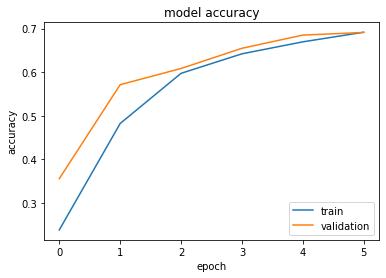

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

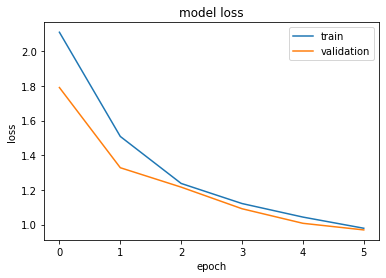

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
model.evaluate(test_images_gray, cat_test_labels, verbose = 2)

814/814 - 1s - loss: 1.0643 - accuracy: 0.6718


[1.0643121004104614, 0.6717501282691956]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [23]:
def create_conv_model():
  conv_model = Sequential([
      
      Conv2D(filters = 32,kernel_size = 3, activation='relu', input_shape=(32, 32,1)),
      MaxPooling2D(pool_size = (2,2)),
      BatchNormalization(),
      Conv2D(filters = 64,kernel_size = 3, activation='relu'),
      MaxPooling2D(pool_size = (2,2)),
      BatchNormalization(),
      Flatten(),
      Dense(units = 64,activation = 'relu'),
      Dropout(0.4),
      Dense(units = 32,activation = 'relu'),
      Dropout(0.4),
      Dense(units = 10,activation = 'softmax')
  ])

  conv_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])
  return conv_model

In [24]:
conv_model = create_conv_model()
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [25]:
class myCallback2(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs["accuracy"] > 0.95:
            print("acc > 0.95, stopping training.....")
            self.model.stop_training = True
            
modelCheck_conv = ModelCheckpoint("conv_model_checkpoint/checkpoint",
                            monitor = "val_accuracy",
                            save_best_only=True,
                            save_weights_only=True,
                            verbose = 1
                           )

callbacks2 = [myCallback2(), modelCheck_conv]

In [26]:
history2 = conv_model.fit(train_images_gray.reshape(-1,32,32,1), cat_train_labels,validation_split = 0.15,
                    epochs = 30, batch_size = 128, callbacks=callbacks2)

Epoch 1/30
487/487 [==============================] - 32s 7ms/step - loss: 1.4171 - accuracy: 0.5325 - val_loss: 1.6268 - val_accuracy: 0.4589

Epoch 00001: val_accuracy improved from -inf to 0.45891, saving model to conv_model_checkpoint/checkpoint
Epoch 2/30
487/487 [==============================] - 3s 6ms/step - loss: 0.7565 - accuracy: 0.7751 - val_loss: 0.5855 - val_accuracy: 0.8265

Epoch 00002: val_accuracy improved from 0.45891 to 0.82646, saving model to conv_model_checkpoint/checkpoint
Epoch 3/30
487/487 [==============================] - 3s 6ms/step - loss: 0.6205 - accuracy: 0.8203 - val_loss: 0.5049 - val_accuracy: 0.8534

Epoch 00003: val_accuracy improved from 0.82646 to 0.85340, saving model to conv_model_checkpoint/checkpoint
Epoch 4/30
487/487 [==============================] - 3s 6ms/step - loss: 0.5547 - accuracy: 0.8417 - val_loss: 0.5149 - val_accuracy: 0.8474

Epoch 00004: val_accuracy did not improve from 0.85340
Epoch 5/30
487/487 [============================

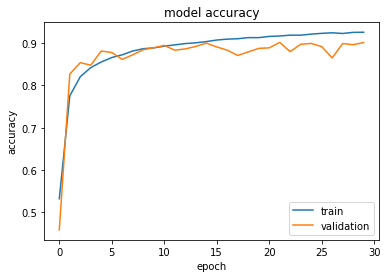

In [28]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

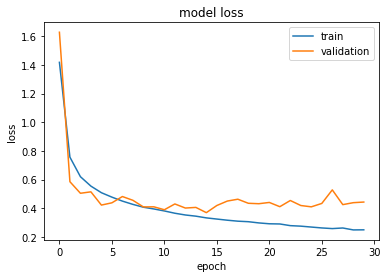

In [27]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [35]:
conv_model.evaluate(test_images_gray.reshape(-1,32,32,1), cat_test_labels, verbose = 2)

814/814 - 2s - loss: 0.4832 - accuracy: 0.8906


[0.48316434025764465, 0.8905962109565735]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [36]:
best_mlp = create_mlp()
best_mlp.load_weights("/content/model_checkpoint/checkpoint")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
Total params: 182,026
Trainable params: 182,026
Non-trainable params: 0
________________________________________________

In [37]:
best_conv = create_conv_model()
best_conv.load_weights("/content/conv_model_checkpoint/checkpoint")

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


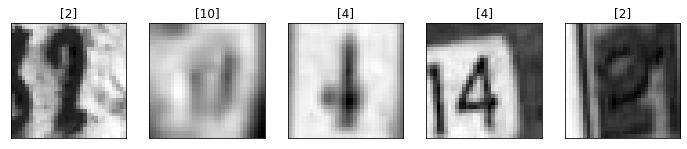

In [39]:
indices = np.random.choice(train_images_gray.shape[0], size = 5, replace = False)
samples2 = train_images_gray[indices,:, :]
labels = train_labels[indices]

plt.figure(figsize=(12, 5)) 
for i in range(samples2.shape[0]):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples2[i,:,:], cmap ='gray')
    plt.title(labels[i])
    plt.xticks([])
    plt.yticks([])

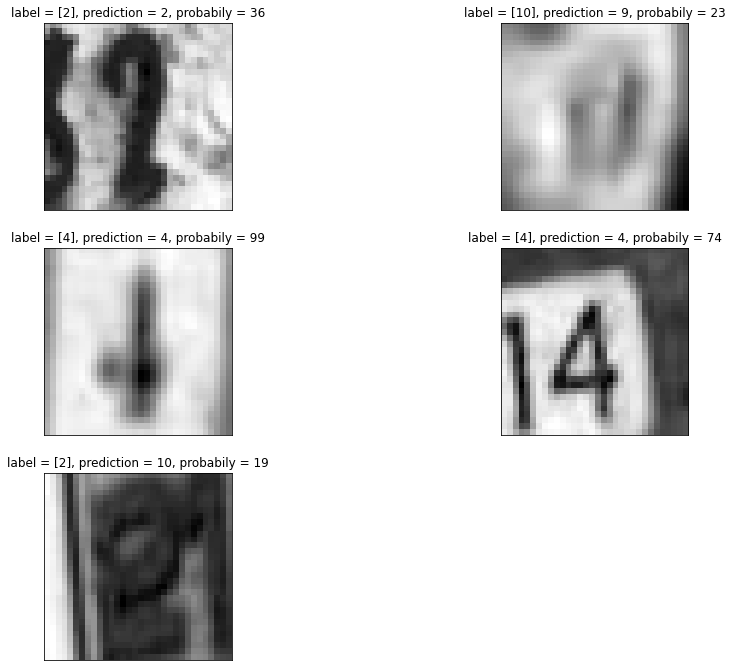

In [54]:
mlp_prediction = best_mlp.predict(samples2)
classes = np.argmax(mlp_prediction, axis = 1) + 1 # because categorical fit step, thus true class is pred + 1

plt.figure(figsize=(15, 20))

for i in range(samples2.shape[0]):
    plt.subplot(5,2, i+1)
    plt.imshow(samples2[i,:,:], cmap ='gray')
    plt.title(f"label = {labels[i]}, prediction = {classes[i]}, probabily = {int(mlp_prediction[i,classes[i]-1] * 100)}")
    plt.xticks([])
    plt.yticks([])

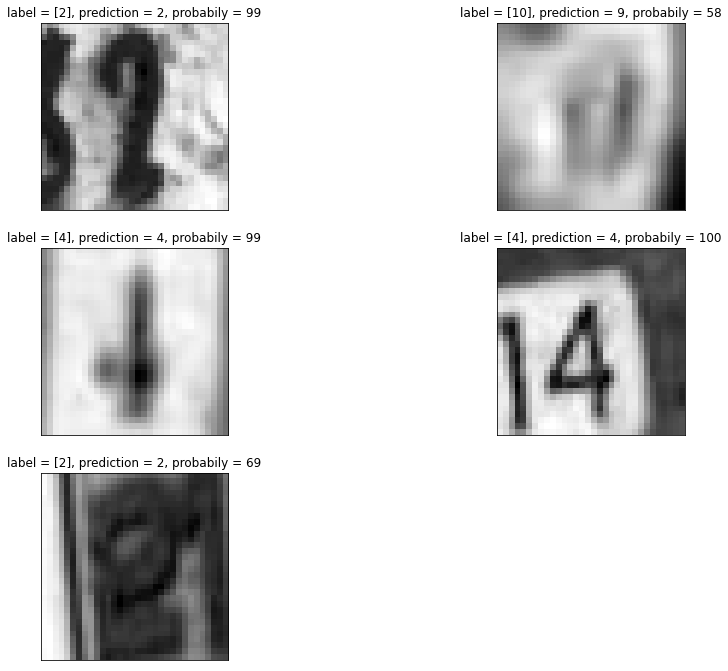

In [60]:
conv_prediction = best_conv.predict(samples2.reshape(-1,32,32,1))
classes = np.argmax(conv_prediction, axis = 1) + 1 # because categorical fit step,thus true class is pred + 1

plt.figure(figsize=(15, 20))

for i in range(samples2.shape[0]):
    plt.subplot(5,2, i+1)
    plt.imshow(samples2[i,:,:], cmap ='gray')
    plt.title(f"label = {labels[i]}, prediction = {classes[i]}, probabily = {int(conv_prediction[i,classes[i]-1] * 100)}")
    plt.xticks([])
    plt.yticks([])